# Probing Density

In [1]:
import matplotlib.pyplot as plt
import random
import numpy as np
random.seed(1337)

On a 1-dimensional interval [0,1] there exists $n$ points. We know nothing the distribution of dots or how many of them there are. However, we do know that there's a minimum distance $d$ between the dots. This is given to us as prior information.

We have one tool to our disposal: a probe. We can give the probe a position $x \in [0,1]$ and it will return the coordinates to the closest left and right dots. We define it as $probe(x): x \in [0,1] \rightarrow (l,r)$ where $l,r \in [0,1]$.

Our task is to approximate the number of dots that's present in the interval. Remember that we can assume nothing about the distribution of dots, as they are placed *arbitrarily*.

### The Probe Function
The probe function looks through the list of (sorted) generated dots and finds the dots left and right of the probed position.

In [2]:
def probe(x, dots):
    N = len(dots)
    for i, dot in enumerate(dots[:-1]):
        if x > dot:
            continue
        else:
            if i - 1 < 0:
                l = None
                r = dots[i]
            else:
                l = dots[i]
                r = dots[i+1]

            return (l,r)
            
    # If we get to the end there's no dots left of x
    return (dots[-1], None)

In [3]:
def get_avg_dist(dots):
    dots.sort()
    intervals = [(i,j) for i,j in zip(dots, dots[1:])]
    dists = np.array([intv[1]-intv[0] for intv in intervals])
    return dists.mean()

## The Intervals

Let's visualize the interval with dots by placing 100 dots in a random fashion. With the contraint that a point cannot be closer than $d$ from any other point. We'll set $d = 0.05$ for now 

In [4]:
N = 100
d = 0.001
def generate_dots(N, d, distribution_fn):
    dots = []
    for i in range(N):
        # not the most efficient but will do for now
        dots.sort()

        if len(dots) < 1:
            x = distribution_fn()
            dots.append(x)
            continue
        
        too_close = True
        while too_close:
            x = distribution_fn()
            too_close = False
            for dot in dots:
                if abs(x - dot) < d:
                    too_close = True
                    break
            
            if not too_close:
                dots.append(x)

    return dots

In [5]:
def plot_interval(dots, title='Our beautiful interval'):
    N = len(dots)
    y = [0 for i in range(N)]
    plt.figure(figsize=(20,8))
    plt.hlines(0,0,1, alpha=0.3)
    plt.scatter(dots, y, s=50, facecolors='none', edgecolors='r', label='N = %d' % (N))
    plt.title(title)
    plt.legend()
    plt.show()

### Uniform Interval

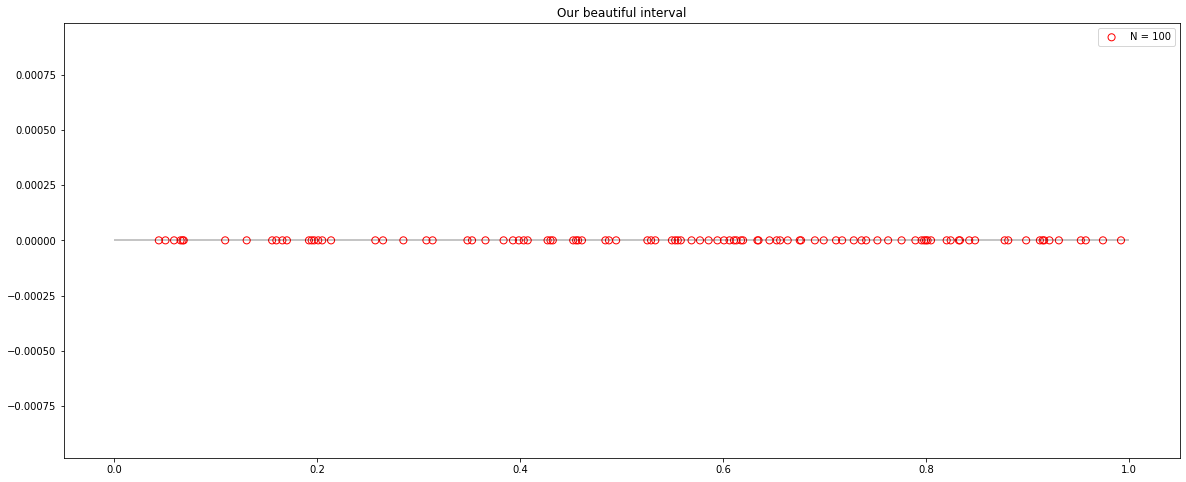

N from average distance:  104.3900036088235


In [6]:
def custom_randunif():
    return random.uniform(0,1)

dots = generate_dots(N,d, custom_randunif)
plot_interval(dots)
print('N from average distance: ', 1 / get_avg_dist(dots))

Let's double check that the generated points follow the distance constraint:

In [7]:
dts = np.array(dots)
dts2 = np.roll(np.copy(dts), -1)
diff = np.abs(dts-dts2)
diff = diff[:-1]
min_dist = diff.min()
max_dist = diff.max()
print("Min distance: %.6f" % min_dist)
print("Max distance: %.6f" % max_dist)

Min distance: 0.001019
Max distance: 0.043637


### Gaussian Interval

Let's make an interval with normally distributed points

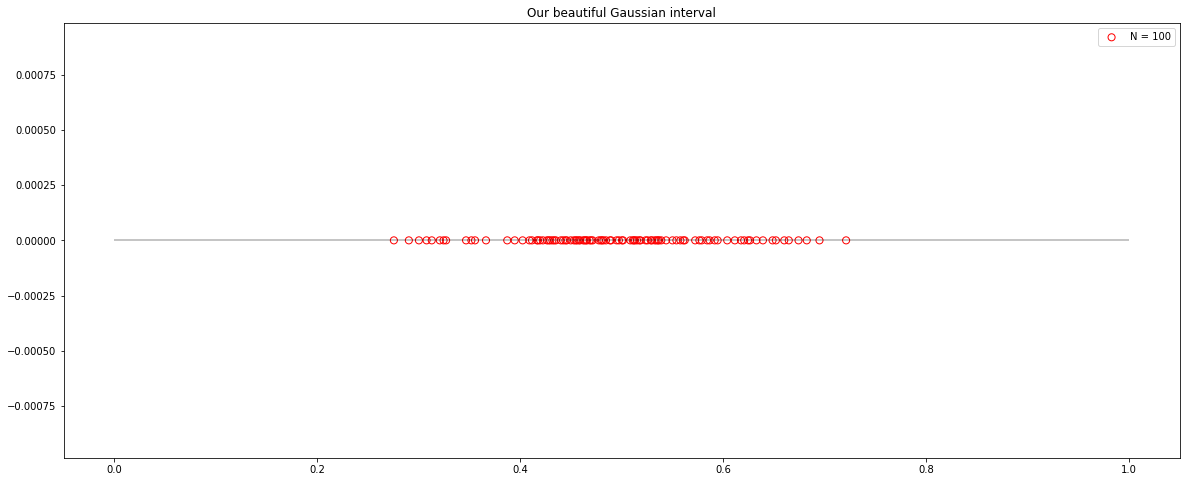

N from average distance:  222.0963477386669


In [8]:
def custom_gaussian():
    return random.gauss(0.5, 0.1)

dots_gauss = generate_dots(N,d, custom_gaussian)
plot_interval(dots_gauss, "Our beautiful Gaussian interval")
print('N from average distance: ', 1 / get_avg_dist(dots_gauss))

### Clusters Interval

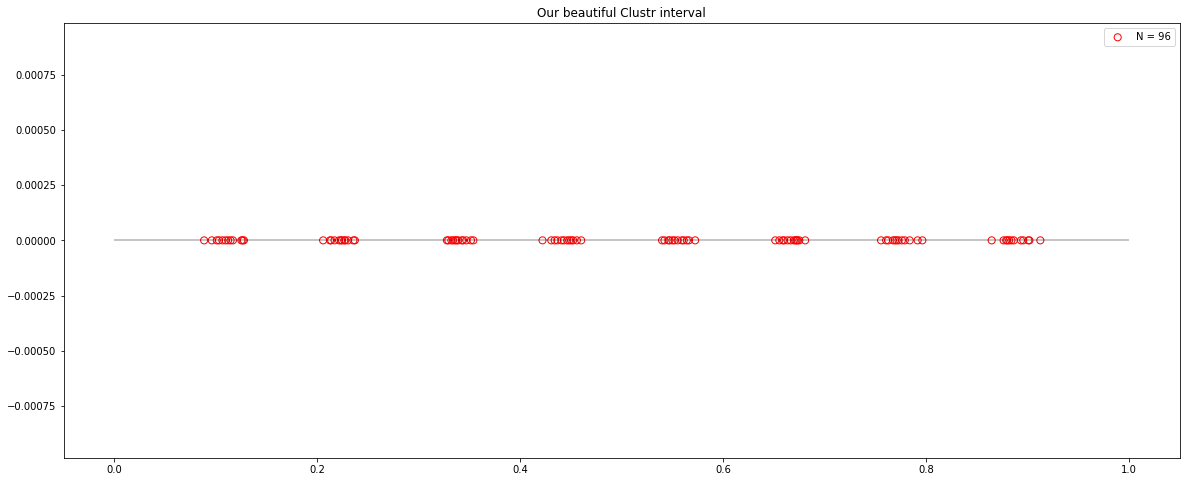

In [9]:
def generate_clustrs(N, d, num_clusters = 8, std=0.01):
    mu_range = np.arange(0,1,1/(num_clusters+1))
    mu_range = mu_range[1:]
    dots_clustrs = []
    for i in range(num_clusters):
        def custom_clustrs():
            return random.gauss(mu_range[i], std)
            generate_dots(N//num_clusters,d, custom_clustrs1)

        clust = generate_dots(N//num_clusters, d, custom_clustrs)
        dots_clustrs.append(clust)

    dots_clustrs = np.array(dots_clustrs).flatten()
    return dots_clustrs

dots_clustrs = generate_clustrs(N, d)
plot_interval(dots_clustrs, "Our beautiful Clustr interval")

Let's create a function for which we can specify a number of dots and a type of distribution

In [10]:
def create_dots_distr(N, type='uniform'):
    d = (1 / N) * 0.01
    if type == 'uniform':
        return generate_dots(N,d, custom_randunif)
    if type == 'gaussian':
        return generate_dots(N,d, custom_gaussian)
    if type == 'clusters':
        return generate_clustrs(N, d)

## A Simple Randomized Approach

One metric is the mean distance between points, $\bar{d}$. The inverse of $\bar{d}$ can be used to approximate the number of points $\bar{n} = 1 / \bar{d}$. 

One approach is to simply probe the line $k$ times and try to get a mean distance between the dots.

In [11]:
import numpy as np

def simple_probing(dots, k, a, b):
    distances = []
    dots.sort()
    
    for i in range(k):
        x = random.uniform(a,b)
        l,r = probe(x, dots)
        # For now we skip edges
        if l and r:
            d = r - l
            distances.append(d)

    if len(distances):
        dists = np.array(distances)
        d_mean = dists.mean()
        return (b-a) / d_mean, d_mean
    else:
        return 0, 0


## Simple Randomized Approach no Replacement

In [12]:
def simple_probing_no_replacement(dots, n_probes, a, b):
    dots.sort()
    start_ix = -1
    end_ix = -1
    
    for i_dot, dot_pos in enumerate(dots):
        if dot_pos > a and start_ix == -1:
            start_ix = i_dot
        if dot_pos > b and end_ix == -1:
            end_ix = i_dot
            
    dots = dots[start_ix:end_ix]
    
    if (len(dots) < 1):
        return 0
    
    if (len(dots) < 2):
        return 1
        
    intervals = [(i,j) for i,j in zip(dots, dots[1:])]

    if n_probes > len(intervals):
        n_probes = len(intervals)
        
    dists = [r-l for (l,r) in random.sample(intervals, n_probes)]
    dists = np.array(dists)
    d_mean = dists.mean()
    return (b-a) / d_mean

Let's run the simple probing algorithm and see some approximations

### Simple Randomized Approach on Uniform Interval

In [15]:
approximations = []
for i in range(10000):
    n_approx, _ = simple_probing(dots, 100, 0, 1)
    approximations.append(n_approx)

aprx = np.array(approximations)

Sample Distribution Mean: 108.76
Sample Distribution STD: 10.00


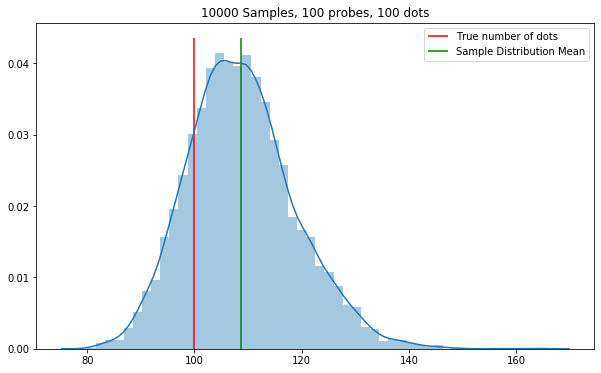

In [16]:
import seaborn as sns
def plot_sample_dist(aprx, N, n_probes=100):
    plt.figure(figsize=(10,6))
    sd_mean = aprx.mean();
    sd_std = aprx.std();
    print("Sample Distribution Mean: %.2f" % sd_mean)
    print("Sample Distribution STD: %.2f" % sd_std)
    sns.distplot(aprx);
    ylim = plt.gca().get_ylim()
    line_height = ylim[1]
    plt.vlines(N, 0, line_height, colors='r', label='True number of dots')
    plt.vlines(aprx.mean(), 0, line_height, colors='g', label='Sample Distribution Mean')
    plt.legend()
    plt.title('%d Samples, %d probes, %d dots' % (aprx.size, n_probes, N))
    plt.show()

plot_sample_dist(aprx, N)

Looks pretty neat! The barplot makes it look like we're ways off, but in reality we are not.

#### Error Rate as we increase N

In [23]:
def test_error_rate(probing_fn='simple_probe', distr_type='uniform', Ns = [50, 100, 200, 500, 1000, 2000]):
    err_runs = 10
    relative_err_means = []
    relative_err_std = []
    for n in Ns:
        print("Testing %d dots..." % (n))
        rel_errs = []
        for i_run in range(err_runs):
            d_n = (1 / n) * 0.01
            approximations = []
            dots_n = create_dots_distr(n, distr_type)
            
            for i in range(100):
                if probing_fn == 'simple_probe':
                    n_approx, _ = simple_probing(dots_n, 100, 0, 1)
                elif probing_fn == 'simple_probe_no_replacement':
                    n_probes = n // 10
                    n_approx = simple_probing_no_replacement(dots_n, n_probes, 0, 1)
                    
                approximations.append(n_approx)

            aprx = np.array(approximations)
            sd_mean = aprx.mean();
            sd_std = aprx.std();
            rel_errs.append(abs(sd_mean-n)/n)

        errs_np = np.array(rel_errs)
        relative_err_means.append(errs_np.mean())
        relative_err_std.append(errs_np.std())
        print("On average the approximation error is: %.4f %%" % (errs_np.mean() * 100))
        print("The error deviates with: %.4f %%\n" % (errs_np.std()*100))
        
    return Ns, relative_err_means, relative_err_std

In [24]:
Ns, relative_err_means, relative_err_std = test_error_rate()

Testing 50 dots...
On average the approximation error is: 11.3805 %
The error deviates with: 10.6409 %

Testing 100 dots...
On average the approximation error is: 12.5144 %
The error deviates with: 7.4860 %

Testing 200 dots...
On average the approximation error is: 6.5050 %
The error deviates with: 3.7708 %

Testing 500 dots...
On average the approximation error is: 4.8357 %
The error deviates with: 2.9778 %

Testing 1000 dots...
On average the approximation error is: 3.0316 %
The error deviates with: 1.8807 %

Testing 2000 dots...
On average the approximation error is: 2.0168 %
The error deviates with: 1.7971 %



In [25]:
def plot_error_rate(Ns, relative_err_means, relative_err_std, title='% Error vs N'):
    plt.figure(figsize=(10,6))
    plt.errorbar(Ns, np.array(relative_err_means)*100, yerr=np.array(relative_err_std)*100, capsize=4, ecolor='r',
                label='Error std')
    plt.xlabel('Number of dots')
    plt.ylabel('% Error')
    plt.legend()
    plt.title(title)
    plt.show()

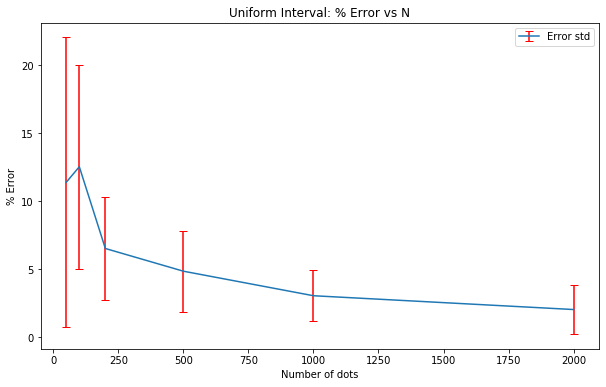

In [26]:
plot_error_rate(Ns, relative_err_means, relative_err_std, title='Uniform Interval: % Error vs N')

### Simple Randomized Approach on Gaussian dots

Sample Distribution Mean: 171.46
Sample Distribution STD: 24.10


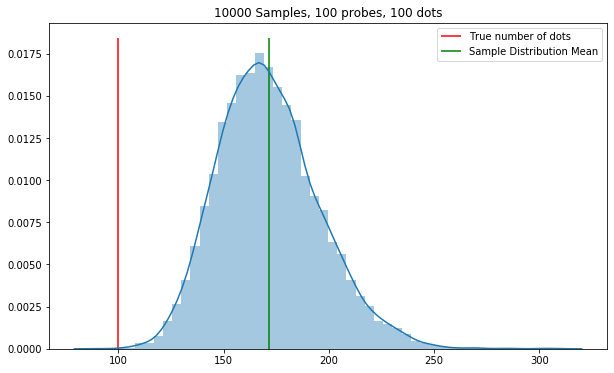

In [28]:
approximations = []
for i in range(10000):
    n_approx, _ = simple_probing(dots_gauss, 100, 0, 1)
    approximations.append(n_approx)

aprx = np.array(approximations)
plot_sample_dist(aprx, 100)

Oh well, this did now work very well

#### Testing the error rate on gaussian interval

Testing 50 dots...
On average the approximation error is: 121.0197 %
The error deviates with: 75.2456 %

Testing 100 dots...
On average the approximation error is: 38.8031 %
The error deviates with: 27.7333 %

Testing 200 dots...
On average the approximation error is: 28.3944 %
The error deviates with: 18.6288 %

Testing 500 dots...
On average the approximation error is: 47.8749 %
The error deviates with: 16.7404 %

Testing 1000 dots...
On average the approximation error is: 65.8447 %
The error deviates with: 11.8810 %

Testing 2000 dots...
On average the approximation error is: 69.9604 %
The error deviates with: 9.9936 %



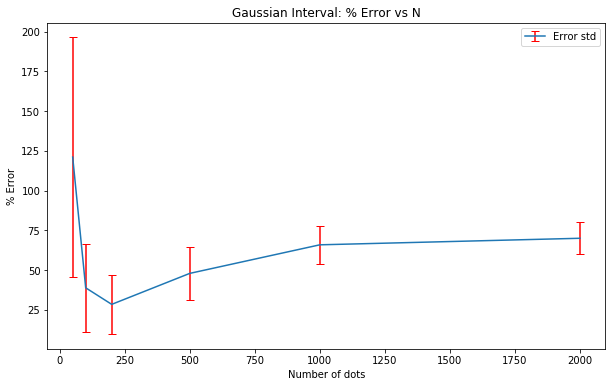

In [29]:
Ns, relative_err_means, relative_err_std = test_error_rate(distr_type='gaussian')
plot_error_rate(Ns, relative_err_means, relative_err_std, title='Gaussian Interval: % Error vs N')

### Simple Randomized Approach on Clustered dots

Sample Distribution Mean: 151.83
Sample Distribution STD: 31.80


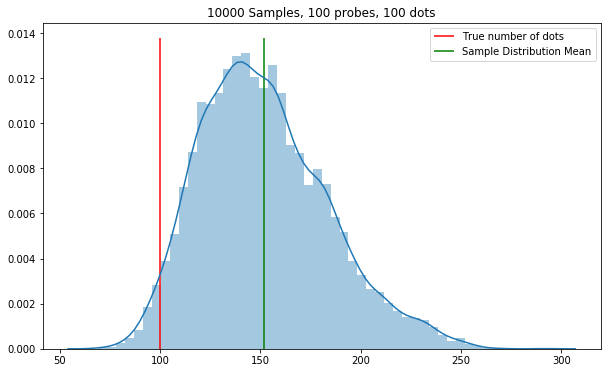

In [30]:
approximations = []
for i in range(10000):
    n_approx, _ = simple_probing(dots_clustrs, 100, 0, 1)
    approximations.append(n_approx)

aprx = np.array(approximations)
plot_sample_dist(aprx, 100)

#### Testing the error rate on cluster interval

Testing 50 dots...
On average the approximation error is: 101.1415 %
The error deviates with: 37.0953 %

Testing 100 dots...
On average the approximation error is: 41.4701 %
The error deviates with: 29.1455 %

Testing 200 dots...
On average the approximation error is: 16.8988 %
The error deviates with: 12.8774 %

Testing 500 dots...
On average the approximation error is: 46.9123 %
The error deviates with: 10.8477 %

Testing 1000 dots...
On average the approximation error is: 63.5895 %
The error deviates with: 7.8356 %

Testing 2000 dots...
On average the approximation error is: 82.5337 %
The error deviates with: 4.6419 %



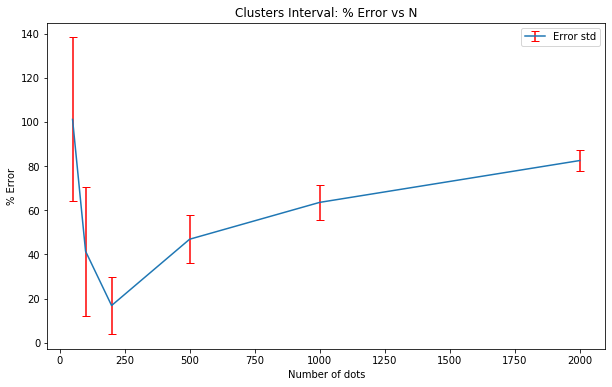

In [31]:
Ns, relative_err_means, relative_err_std = test_error_rate(distr_type='clusters')
plot_error_rate(Ns, relative_err_means, relative_err_std, title='Clusters Interval: % Error vs N')

## Interval Inception

Let's try to divide the interval into... more intervals! And maybe our accuracy will improve.

Let's divide the main interval into $m$ subintervals and probe each of them separately.

In [37]:
def create_intervals(m):
    step = 1 / m
    interval_borders = np.arange(0,1 + step, step).round(3)
    intervals = [(i,j) for i,j in zip(interval_borders, interval_borders[1:])]
    return intervals


def interval_sampling(dots, n_intervals = 10, n_runs = 100, n_probes = 100):
    results = []
    results_mean_dist = []
    for i in range(n_runs):
        intervals = create_intervals(n_intervals)
        interval_approximations = []
        mean_dist_approximations = []
        for (a,b) in intervals:
            intv_approx, mean_dist_approx = simple_probing(dots,n_probes,a,b)
            interval_approximations.append(intv_approx)
            mean_dist_approximations.append(mean_dist_approx)

        np_ia = np.array(interval_approximations)
        np_da = np.array(mean_dist_approximations)
        n_approx = np_ia.sum()
        results.append(n_approx)
        results_mean_dist.append(np_da.sum())
    
    return results, results_mean_dist

### Interval Sampling on Uniform Interval

Sample Distribution Mean: 114.81
Sample Distribution STD: 4.13


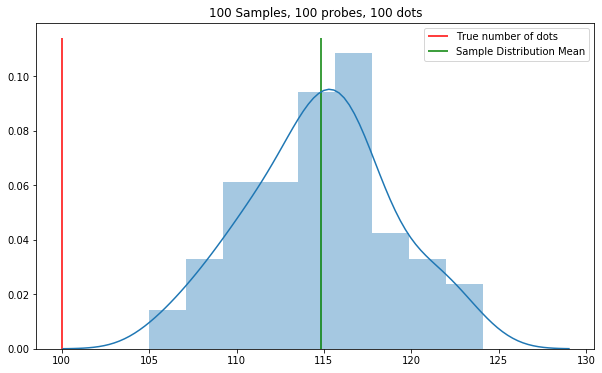

In [38]:
aprx,appx_mean_dist = np.array(interval_sampling(dots, n_intervals=5))
plot_sample_dist(aprx, N)

### Interval Sampling on Gaussian Interval

Sample Distribution Mean: 105.05
Sample Distribution STD: 2.08


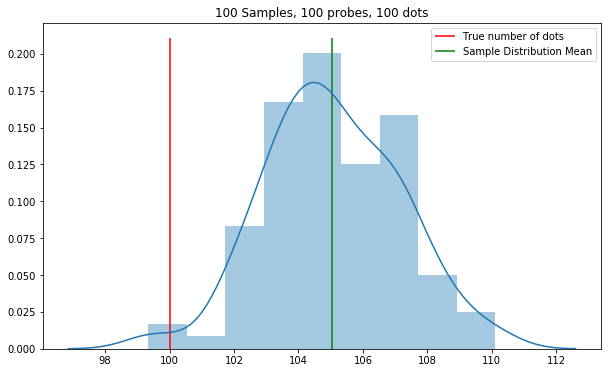

In [39]:
aprx, appx_mean_dist = np.array(interval_sampling(dots_gauss, n_intervals=20))
plot_sample_dist(aprx, N)

Hmmm, so we get a better approximation of gaussian distributed dots when using interval probing

### Interval Sampling on Clustered Interval

Sample Distribution Mean: 168.01
Sample Distribution STD: 5.30


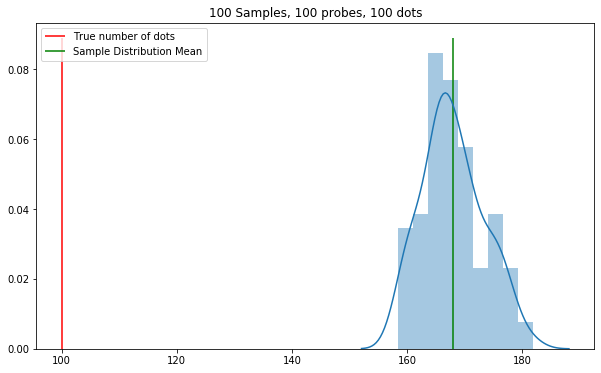

In [40]:
is_clustr, _ = interval_sampling(dots_clustrs, n_intervals=10, n_probes=1000)
aprx = np.array(is_clustr)
plot_sample_dist(aprx, N)

## Method of Jonathan Wizard of Dots

In tales and songs we have heard of a powerful wizard residing in the tower of Johanneberg. His approach is to never plot the same interval between two points twice. Meaning that this distance will only be registered once. The theory is that this will work better for finding clusters.


![jonafan](https://media1.tenor.com/images/9d36d3de117eb90606ae5380f867109b/tenor.gif?itemid=14960251 "jonafan")

In [54]:
N_j = 1000
d_j = 0.0001
dots_j = generate_dots(N_j, d_j, custom_randunif)
dots_gauss_j = generate_dots(N_j, d_j, custom_gaussian)
dots_clustrs_j = generate_clustrs(N_j, d_j)

Sample Distribution Mean: 1008.25
Sample Distribution STD: 91.48


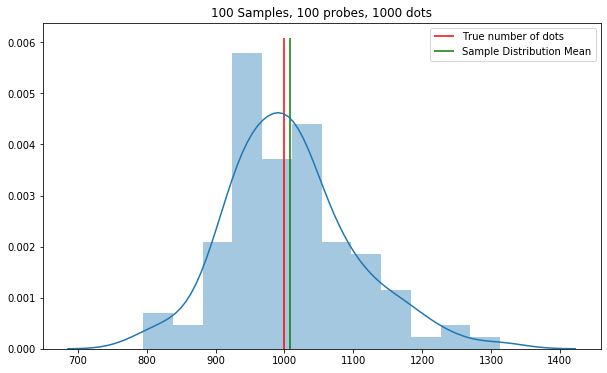

Testing 50 dots...
On average the approximation error is: 21.3328 %
The error deviates with: 8.2868 %

Testing 100 dots...
On average the approximation error is: 11.3967 %
The error deviates with: 4.0441 %

Testing 200 dots...
On average the approximation error is: 4.7645 %
The error deviates with: 1.8215 %

Testing 500 dots...
On average the approximation error is: 2.4743 %
The error deviates with: 0.8480 %

Testing 1000 dots...
On average the approximation error is: 1.0574 %
The error deviates with: 0.8606 %

Testing 2000 dots...
On average the approximation error is: 0.7754 %
The error deviates with: 0.6424 %



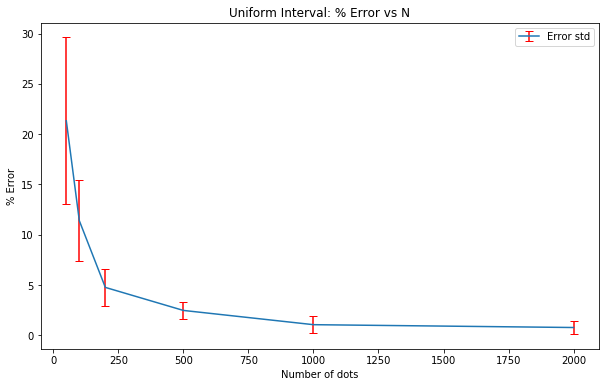

In [55]:
approximations = []
for i in range(100):
    n_approx = simple_probing_no_replacement(dots_j, 100, 0, 1)
    approximations.append(n_approx)

aprx = np.array(approximations)
plot_sample_dist(aprx, N_j, n_probes=100)

Ns, relative_err_means, relative_err_std = test_error_rate(probing_fn='simple_probe_no_replacement')
plot_error_rate(Ns, relative_err_means, relative_err_std, title='Uniform Interval: % Error vs N')

Sample Distribution Mean: 1828.97
Sample Distribution STD: 343.85


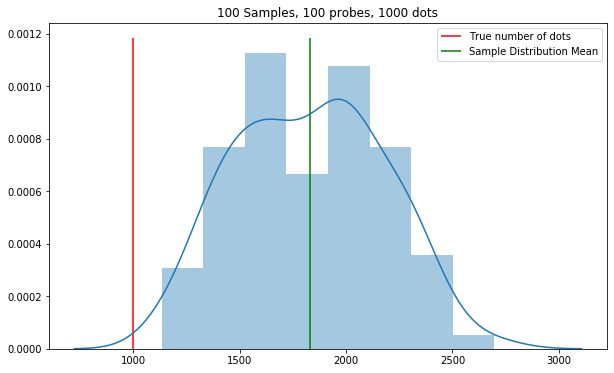

Testing 50 dots...
On average the approximation error is: 198.1044 %
The error deviates with: 25.8404 %

Testing 100 dots...
On average the approximation error is: 170.4331 %
The error deviates with: 21.4564 %

Testing 200 dots...
On average the approximation error is: 116.4611 %
The error deviates with: 11.5151 %

Testing 500 dots...
On average the approximation error is: 89.7246 %
The error deviates with: 12.9836 %

Testing 1000 dots...
On average the approximation error is: 70.5596 %
The error deviates with: 7.8368 %

Testing 2000 dots...
On average the approximation error is: 61.9807 %
The error deviates with: 9.3968 %



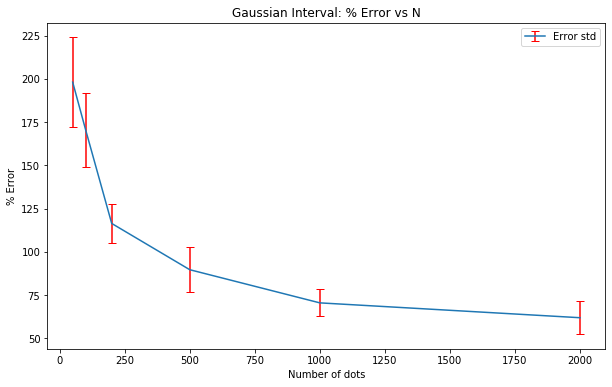

In [56]:
approximations = []
for i in range(100):
    n_approx = simple_probing_no_replacement(dots_gauss_j, 100, 0, 1)
    approximations.append(n_approx)

aprx = np.array(approximations)
plot_sample_dist(aprx, N_j, n_probes=100)

Ns, relative_err_means, relative_err_std = test_error_rate(probing_fn='simple_probe_no_replacement', distr_type='gaussian')
plot_error_rate(Ns, relative_err_means, relative_err_std, title='Gaussian Interval: % Error vs N')

Sample Distribution Mean: 1623.81
Sample Distribution STD: 857.16


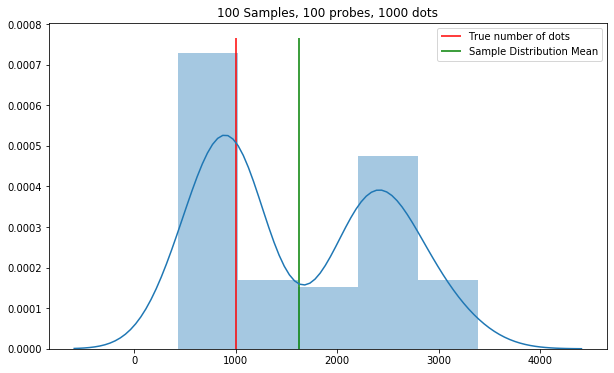

In [57]:
approximations = []
for i in range(100):
    n_approx = simple_probing_no_replacement(dots_clustrs_j, 100, 0, 1)
    approximations.append(n_approx)

aprx = np.array(approximations)
plot_sample_dist(aprx, N_j, n_probes=100)

In [62]:
def interval_sampling_no_replace(dots, n_intervals = 10, n_runs = 100, percentage_dots=0.1):
    results = []
    for i in range(n_runs):
        intervals = create_intervals(n_intervals)
        interval_approximations = []
        for (a,b) in intervals:
            n_probes = int(len(dots) * percentage_dots)
            intv_approx = simple_probing_no_replacement(dots,n_probes,a,b)
            interval_approximations.append(intv_approx)

        np_ia = np.array(interval_approximations)
        n_approx = np_ia.sum()
        results.append(n_approx)
    
    return results

Sample Distribution Mean: 1091.68
Sample Distribution STD: 54.68


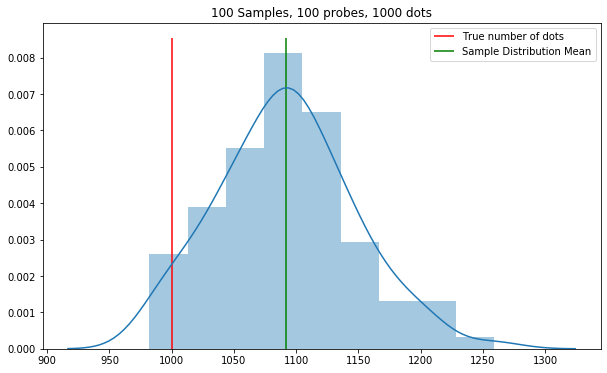

In [63]:
is_clustr = interval_sampling_no_replace(dots_j, n_intervals=30, percentage_dots=0.01, n_runs=100)
aprx = np.array(is_clustr)
plot_sample_dist(aprx, N_j)

Sample Distribution Mean: 1064.34
Sample Distribution STD: 68.96


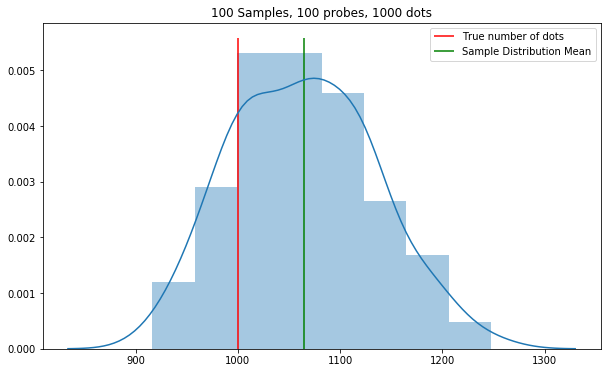

In [64]:
is_clustr = interval_sampling_no_replace(dots_gauss_j, n_intervals=30, percentage_dots=0.01, n_runs=100)
aprx = np.array(is_clustr)
plot_sample_dist(aprx, N_j)

Sample Distribution Mean: 2204.05
Sample Distribution STD: 35.00


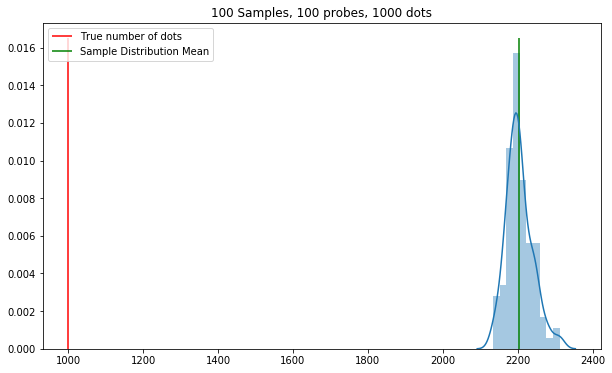

In [96]:
is_clustr = interval_sampling_no_replace(dots_clustrs_j, n_intervals=10, percentage_dots=0.1, n_runs=100)
aprx = np.array(is_clustr)
plot_sample_dist(aprx, N_j)

# A different approach: Trying to infer the total by method of exclusion

We know that the number of dots cannot be any close to each other than $d$

In [69]:
def deduction_probing(dots, n_probes, d):
    dots.sort()
    
    intervals = [(i,j) for i,j in zip(dots, dots[1:])]

    if n_probes > len(intervals):
        n_probes = len(intervals)
        
    dists = np.array([r-l for (l,r) in random.sample(intervals, n_probes)])
    probed_dist = dists.sum()
    remaining_dist = 1 - probed_dist
    return remaining_dist / d

In [70]:
deduction_probing(dots, 10, d)

885.9683671565068

Well, eh, this was not a good approach

# Making Random Interval Lengths

In [81]:
def create_random_intervals(m):
    step = 1 / m
    interval_borders = np.array(sorted(random.sample(list(np.arange(0,1,m*0.001)), m))).round(int(np.log10(m)))
    intervals = [(i,j) for i,j in zip(interval_borders, interval_borders[1:])]
    return intervals


def random_interval_sampling(dots, n_intervals = 10, n_runs = 100, n_probes = 100):
    results = []
    for i in range(n_runs):
        intervals = create_random_intervals(n_intervals)
        interval_approximations = []
        for (a,b) in intervals:
            intv_approx = simple_probing(dots,n_probes,a,b)
            interval_approximations.append(intv_approx)

        np_ia = np.array(interval_approximations)
        n_approx = np_ia.sum()
        results.append(n_approx)
    
    return results

Sample Distribution Mean: 102.73
Sample Distribution STD: 27.96


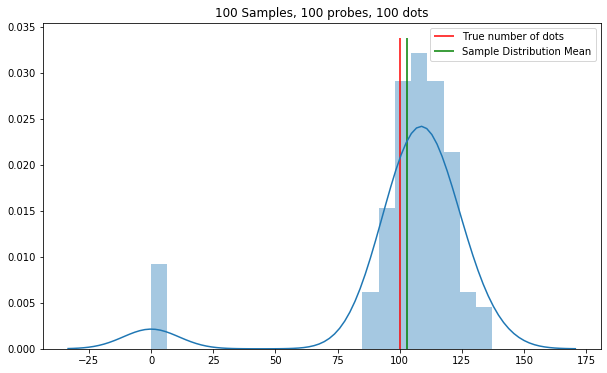

In [82]:
aprx = np.array(random_interval_sampling(dots, n_intervals=5, n_runs=100))
plot_sample_dist(aprx, N)

Sample Distribution Mean: 105.22
Sample Distribution STD: 16.24


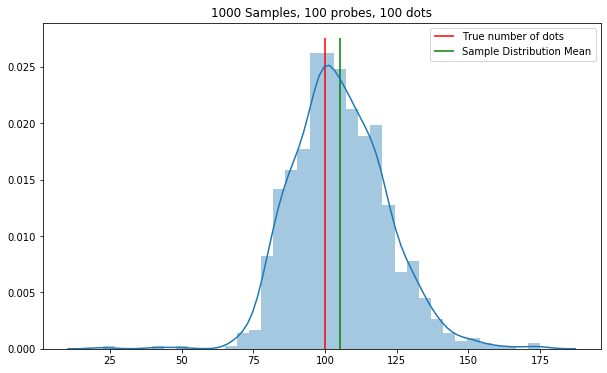

In [91]:
aprx = np.array(random_interval_sampling(dots_gauss, n_intervals=10, n_runs=1000))
plot_sample_dist(aprx, N)

Sample Distribution Mean: 401.69
Sample Distribution STD: 114.89


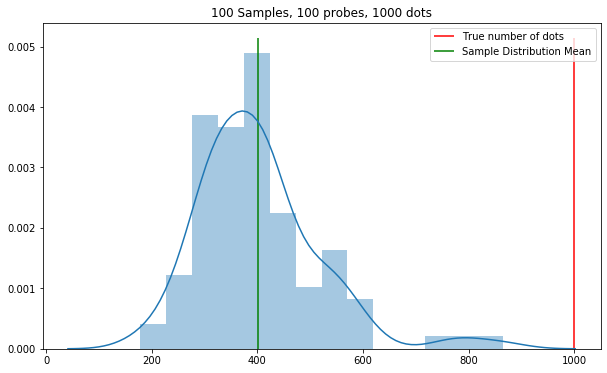

In [97]:
aprx = np.array(random_interval_sampling(dots_clustrs_j, n_intervals=10, n_runs=100))
plot_sample_dist(aprx, N_j)